In [1]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

# !pip install -q torchsummary
# from torchsummary import summary

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output


!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 4.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load Colored MNIST dataset

In [3]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        self.T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            'img': self.T(ims),
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [4]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6038349.84it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 152025.63it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1503492.89it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9444982.04it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000 10000 4926


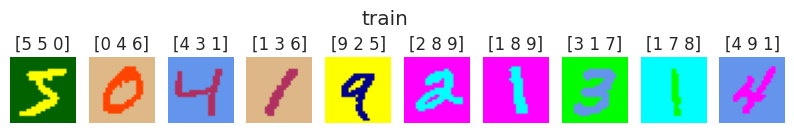

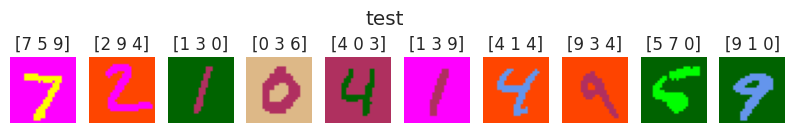

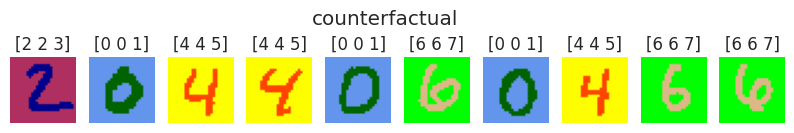

In [5]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [6]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. Build CVAE

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim=2, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3136 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3136 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=2, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=64*7*7)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.first_layer(x).view((-1, 64, 7, 7))
        return self.upsampling_layers(x)

In [8]:
class CVAE(nn.Module):
    def __init__(self, z_dim=2, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def get_one_hot(self, labels):
        new_ys = []
        for i, label_length in enumerate(LABEL_SIZES):
            new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
            new_ys.append(new_y)
        new_ys = torch.cat(new_ys, -1)
        return new_ys.to(torch.float32)

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, self.get_one_hot(labels)], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, self.get_one_hot(labels))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        z_loc, z_scale = self.encoder_(x, y_one_hot)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        loc_img = self.decoder_(torch.cat([z, y_one_hot], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 3. Train CVAE

In [10]:
def plot_image(x):
    plt.figure(figsize=(3, 3))
    plt.imshow(normalize(x.cpu()))
    plt.axis('off')

def plot_img_on_ax(x, ax):
    ax.imshow(normalize(x.cpu()))
    ax.axis('off')

def show_reconstructions(vae, loader, cols=5, rows=1):
    for k, batch in enumerate(loader):
        if k >= rows:
            return
        x = batch['img']
        l = batch['label']
        plt.figure(figsize=(1.5 * cols, 3))
        for i in range(cols):
            plt.subplot(2, cols, i+1)
            plt.imshow(normalize(x[i].permute(1, 2, 0)))
            plt.axis('off')
            plt.subplot(2, cols, i+cols+1)
            rec_img = vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().numpy().transpose((1, 2, 0))
            plt.imshow(normalize(rec_img))
            plt.axis('off')
        plt.tight_layout()

def run_epoch(svi, dataloader, use_cuda=False):
    epoch_loss = 0.
    for batch in dataloader:
        epoch_loss += svi.step(batch['img'], batch['label'])
    return epoch_loss / len(dataloader.dataset)

def callback(train_elbo, test_elbo, test_epoch_num, epoch, vae):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    plt.plot(test_epoch_num, test_elbo, lw=2, color='#FF3300', label='test')
    plt.legend()
    plt.xlabel('epoch')
    plt.title(f'Epoch {epoch}. ELBO {test_elbo[-1]}')
    plt.show()
    vae.train(False);
    show_reconstructions(vae, cf_loader, 2, 1)
    show_reconstructions(vae, test_loader, 2, 1)
    vae.train(True);
    plt.show()


LEARNING_RATE = 5.0e-4
USE_CUDA = torch.cuda.is_available()
pyro.clear_param_store()
adam_args = {"lr": LEARNING_RATE}

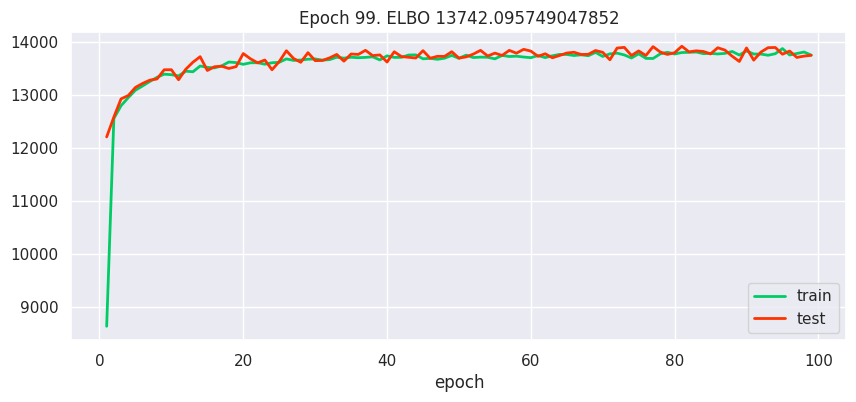

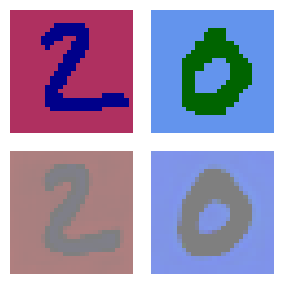

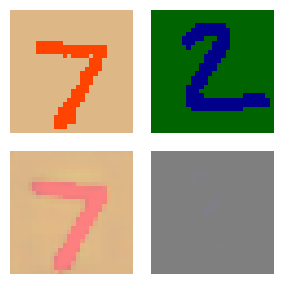

In [ ]:
# 4.1
vae = CVAE(z_dim=10, label_dim=30, p=0.1, use_cuda=USE_CUDA)
optimizer = Adam(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
test_epoch_num = []

for epoch in range(100):
    total_epoch_loss_train = run_epoch(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    total_epoch_loss_test = run_epoch(svi, test_loader, use_cuda=USE_CUDA)
    test_elbo.append(-total_epoch_loss_test)
    test_epoch_num.append(epoch+1)
    if epoch % 2 == 0:
        torch.save(vae.state_dict(), '/content/drive/MyDrive/thesis/05_01_2024/vae_05_01_exp41.pth')
        callback(train_elbo, test_elbo, test_epoch_num, epoch+1, vae)

In [ ]:
np.save('/content/drive/MyDrive/thesis/05_01_2024/vae_05_01_exp41_train_elbo.npy', train_elbo)
np.save('/content/drive/MyDrive/thesis/05_01_2024/vae_05_01_exp41_test_elbo.npy', test_elbo)

### 3.1 CVAE Sanity Checks [CPU]

In [11]:
pyro.clear_param_store()
vae = CVAE(z_dim=10, label_dim=30, p=0.1, use_cuda=USE_CUDA)
vae.load_state_dict(torch.load('/content/drive/MyDrive/thesis/05_01_2024/vae_05_01_exp41.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae.train(False);

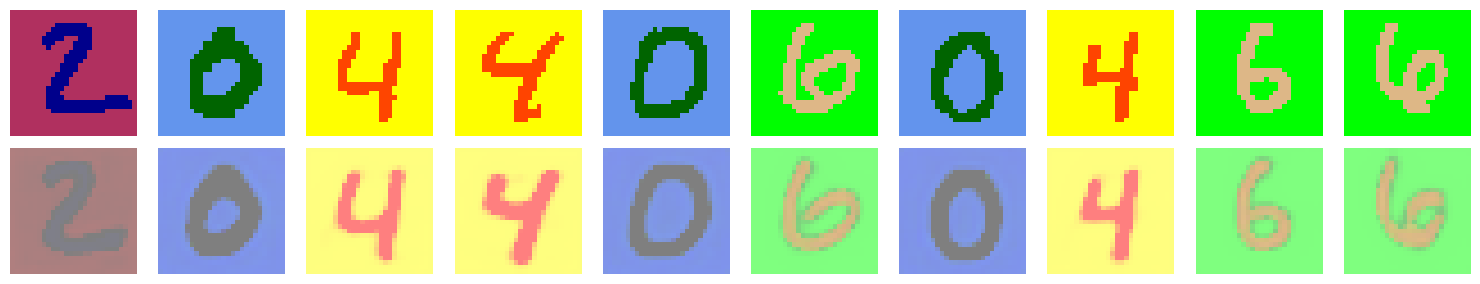

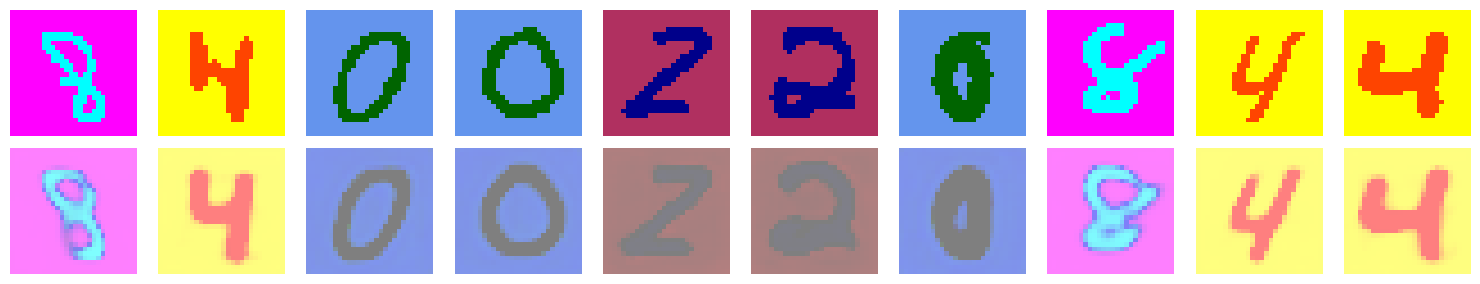

In [ ]:
show_reconstructions(vae, cf_loader, 10, 2);

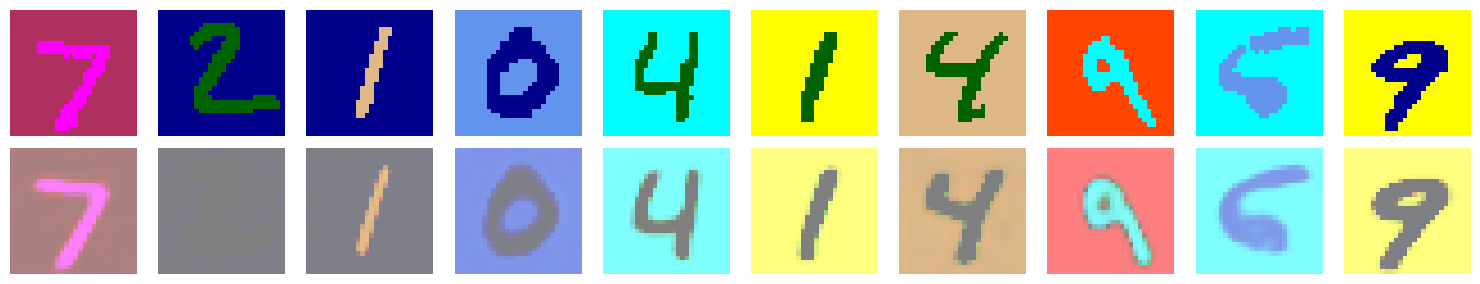

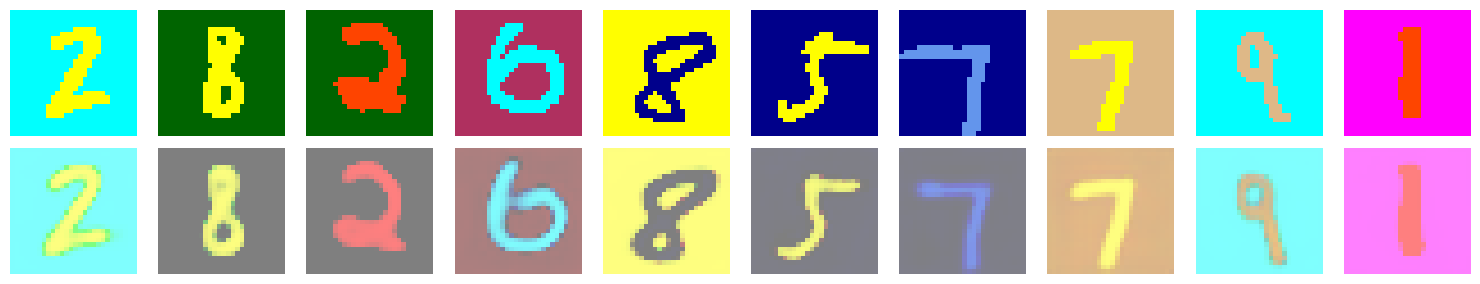

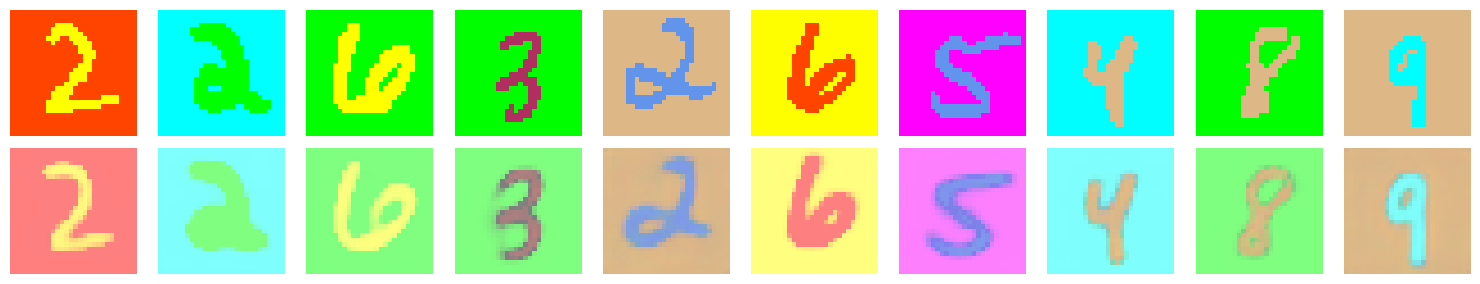

In [ ]:
show_reconstructions(vae, test_loader, 10, 3);

In [ ]:
def compare_imgs(im1, im2, title1, title2):
    f, ax = plt.subplots(1, 2, figsize=(3, 1.5))
    plot_img_on_ax(im1.permute(1,2,0), ax[0])
    ax[0].set_title(title1)
    plot_img_on_ax(im2.permute(1,2,0), ax[1])
    ax[1].set_title(title2)
    plt.show()

In [ ]:
def run_sanity_check_2(vae, test_loader):
    batch = next(iter(test_loader))
    idx = np.random.randint(0, len(batch['label']))
    x = batch['img'][idx:idx+1]
    l = batch['label'][idx:idx+1]
    mu, sigma = vae.encoder(x, l)
    B = 100
    zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for _ in range(B)], 0)
    ys = torch.cat([l for _ in range(B)], 0)
    rs = vae.decoder(zs, ys).detach() # 100, 3, 28, 28
    compare_imgs(x[0], rs.mean(0), l.tolist()[0], l.tolist()[0])

    print('Changing FG color')
    y_new = torch.tensor(l)
    f, ax = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, color_name in color_dict.items():
        y_new[0, 1] = i
        zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for _ in range(B)], 0)
        ys = torch.cat([y_new for _ in range(B)], 0)
        rs = vae.decoder(zs, ys).detach()
        plot_img_on_ax(rs.mean(0).permute(1,2,0), ax[i])
        ax[i].set_title(color_name)
    plt.show()

    print('Changing BG color')
    y_new = torch.tensor(l)
    f, ax = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, color_name in color_dict.items():
        y_new[0, 2] = i
        zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for _ in range(B)], 0)
        ys = torch.cat([y_new for _ in range(B)], 0)
        rs = vae.decoder(zs, ys).detach()
        plot_img_on_ax(rs.mean(0).permute(1,2,0), ax[i])
        ax[i].set_title(color_name)
    plt.show()

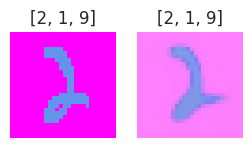

Changing FG color


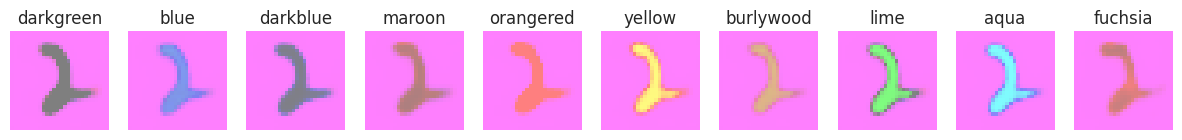

Changing BG color


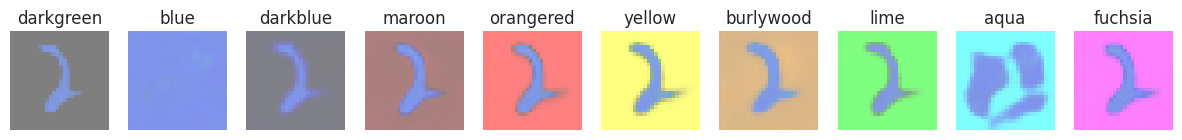

In [ ]:
run_sanity_check_2(vae, test_loader)

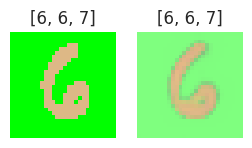

Changing FG color


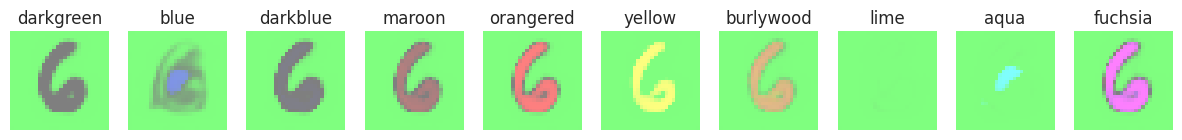

Changing BG color


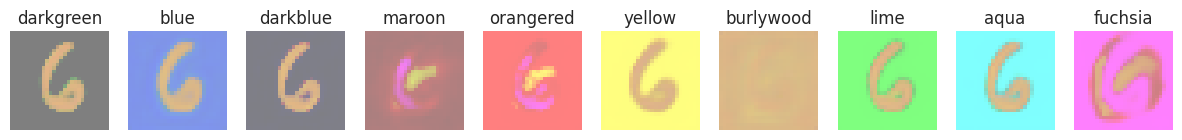

In [ ]:
run_sanity_check_2(vae, cf_loader)

### 4. Create dataset for causica with Ys(3) and Zs(3)

In [ ]:
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
Z_DIM = 10
df = pd.DataFrame(columns=LABEL_NAMES+['z'+str(i) for i in range(Z_DIM)])

for batch in tqdm(train_loader):
    for x, l in zip(batch['img'], batch['label']):
        mu, sigma = vae.encoder(x.unsqueeze(0), l.unsqueeze(0))
        zs = dist.Normal(mu.cpu(), sigma.cpu()).sample()
        df.loc[len(df)] = [s.item() for s in l] + [s.item() for s in zs.flatten()]
df.to_csv('train.csv', index=False, header=False)

100%|██████████| 234/234 [03:55<00:00,  1.01s/it]


Create json for causica:

In [ ]:
import json

def generate_json(z_dim):
    variables = []

    for i in range(3):
        y = {
            "group_name": f"y{i}",
            "name": f"y{i}",
            "type": "categorical"
        }
        variables.append(y)

    # Generating z variables
    for i in range(z_dim):
        z = {
            "group_name": f"z{i}",
            "name": f"z{i}",
            "type": "continuous"
        }
        variables.append(z)

    data = {"variables": variables}

    with open("variables.json", "w") as json_file:
        json.dump(data, json_file, indent=4)
generate_json(10)

In [12]:
### Using Zs in CAUSICA
vardist_mode = np.array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]],
      dtype='float32')

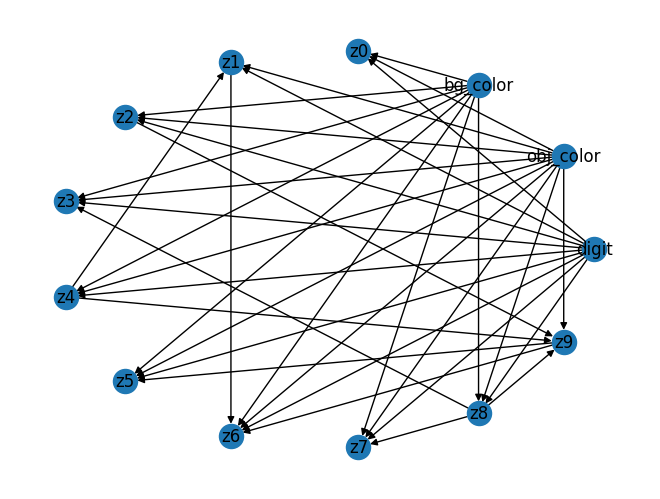

In [13]:
import networkx as nx
Z_DIM = 10
labeldict = {i: l for i, l in enumerate(['digit', 'obj_color', 'bg_color']+['z'+str(j) for j in range(Z_DIM)])}
graph = nx.from_numpy_array(vardist_mode, create_using=nx.DiGraph)
nx.draw_circular(graph, labels=labeldict, with_labels=True, arrows=True)

### 5. Use trained CAUSICA graph to build SCM [LOCAL TRAINING!]

In [14]:
# Getting original image
batch = next(iter(test_loader))
scm_x = batch['img']
scm_y = batch['label']
scm_mu, scm_sigma = vae.encoder(scm_x, scm_y)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [15]:
class SCM():
    def __init__(self, vardist_mode, z_dim=3, num_labels=3, label_sizes=LABEL_SIZES):
        pyro.clear_param_store()
        self.z_names = ['Z'+str(i) for i in range(z_dim)]
        self.var_names = np.array(['Y'+str(i+1) for i in range(num_labels)] + self.z_names)
        self.feat_dims = {k: ls for k, ls in zip(self.var_names, LABEL_SIZES + list(np.ones(z_dim, dtype=int)))}
        self.name_to_num = {k: i for i, k in enumerate(self.var_names)}
        self.vardist_mode = vardist_mode

    @staticmethod
    def get_onehot_bias(Y_parents, Z_parents):
        if len(Y_parents):
            BS = len(Y_parents[0])
        else:
            BS = len(Z_parents[0])
        onehot_bias = []
        for Y in Y_parents:
            onehot_bias.append(F.one_hot(Y.to(torch.int64), num_classes=10).float())
        for Z in Z_parents:
            onehot_bias.append(Z[:, None])
        onehot_bias.append(torch.ones(BS, 1))
        return torch.cat(onehot_bias, dim=1)

    def get_sample_model(self, sample_dict, a, var_name, obs_vectors, sigmas):
        if var_name in sample_dict:
            return sample_dict, a
        BS = len(list(sigmas.values())[0])
        num = self.name_to_num[var_name]
        parents = self.var_names[self.vardist_mode[:, num].astype(bool)]
        if len(parents) == 0:
            a[var_name] = pyro.param('a_'+var_name,
                                     torch.rand((1, self.feat_dims[var_name])),
                                    #  constraint = constraints.interval(-10, 10)
                                     )
            var_mu = a[var_name].repeat(BS, 1)
        else:
            parent_dim = 1
            Y_parents, Z_parents = [], []
            for parent in parents:
                parent_dim += self.feat_dims[parent]
                sample_dict, a = self.get_sample_model(sample_dict, a, parent, obs_vectors, sigmas)
                if parent[0] == 'Y':
                    Y_parents.append(sample_dict[parent])
                elif parent[0] == 'Z':
                    Z_parents.append(sample_dict[parent])
            a[var_name] = pyro.param('a_'+var_name,
                                     torch.rand((parent_dim, self.feat_dims[var_name]))
                                     #  constraint = constraints.interval(-10, 10)
                                     )
            var_mu = self.get_onehot_bias(Y_parents, Z_parents) @ a[var_name]
        if var_name[0] == 'Y':
            sample_dict[var_name] = pyro.sample(var_name, dist.Categorical(logits=var_mu), obs=obs_vectors[var_name])
        else:
            sample_dict[var_name] = pyro.sample(var_name, dist.Normal(var_mu.flatten(), sigmas[var_name]).to_event(1), obs=obs_vectors[var_name])
        return sample_dict, a

    def model(self, sigma, mu, labels):
        sample_dict = {}
        a = {}
        BS = len(sigma)
        sigmas = {k: val for k, val in zip(self.z_names, sigma.T)}
        obs_vectors = {k: val for k, val in zip(self.var_names, torch.cat([labels, mu], dim=1).T)}
        with pyro.plate("data", BS):
            for var_name in self.var_names:
                if var_name not in sample_dict:
                    sample_dict, a = self.get_sample_model(sample_dict, a, var_name, obs_vectors, sigmas)

    def guide(self, sigma, mu, labels):
        pass

### 6. SCM Inference

In [16]:
import pickle
with open('/content/params_zdim10_constrained_reg.pkl', "rb") as f:
    scm_params = pickle.load(f)

In [52]:
class SCM_Inference():
    def __init__(self, vardist_mode, scm_params, vae, z_dim=3, num_labels=3,
                 label_sizes=LABEL_SIZES, BS=8, sigma_=0.2):
        self.z_names = ['Z'+str(i) for i in range(z_dim)]
        self.var_names = np.array(['Y'+str(i+1) for i in range(num_labels)] + self.z_names)
        self.feat_dims = {k: ls for k, ls in zip(self.var_names, LABEL_SIZES + list(np.ones(z_dim, dtype=int)))}
        self.name_to_num = {k: i for i, k in enumerate(self.var_names)}
        self.vardist_mode = vardist_mode
        self.scm_params = scm_params
        self.BS = BS
        self.sigma_ = sigma_
        self.vae = vae

    @staticmethod
    def get_onehot_bias(Y_parents, Z_parents):
        if len(Y_parents):
            BS = len(Y_parents[0])
        else:
            BS = len(Z_parents[0])
        onehot_bias = []
        for Y in Y_parents:
            onehot_bias.append(F.one_hot(Y.to(torch.int64), num_classes=10).float())
        for Z in Z_parents:
            onehot_bias.append(Z[:, None])
        onehot_bias.append(torch.ones(BS, 1))
        return torch.cat(onehot_bias, dim=1)

    def get_sample_inf(self, sample_dict, levels_dict, y_dict, var_name):
        '''sample_dict - dict with samples, changing
        y_dict - consts'''

        if var_name in sample_dict:
            return sample_dict, levels_dict
        num = self.name_to_num[var_name]
        parents = self.var_names[self.vardist_mode[:, num].astype(bool)]
        levels_dict[var_name] = 1
        if len(parents) == 0:
            var_mu = self.scm_params['a_'+var_name].repeat(self.BS, 1)
        else:
            Y_parents, Z_parents = [], []
            for parent in parents:
                sample_dict, levels_dict = self.get_sample_inf(sample_dict, levels_dict, y_dict, parent)
                levels_dict[var_name] = max(levels_dict[var_name], levels_dict[parent] + 1)
                if parent[0] == 'Y':
                    Y_parents.append(sample_dict[parent])
                elif parent[0] == 'Z':
                    Z_parents.append(sample_dict[parent])
            var_mu = self.get_onehot_bias(Y_parents, Z_parents) @ self.scm_params['a_'+var_name]
        if var_name[0] == 'Y':
            # no sampling, Ys are given
            sample_dict[var_name] = torch.tensor(y_dict[var_name]).repeat(self.BS)
        else:
            # sampling, Zs are normal
            coef = 1.2 ** levels_dict[var_name]
            sample_dict[var_name] = dist.Normal(var_mu, coef * self.sigma_).sample().flatten()
        return sample_dict, levels_dict

    def scm_infer(self, ys):
        y_dict = {'Y1': ys[0], 'Y2': ys[1], 'Y3': ys[2]}
        sample_dict = {}
        levels_dict = {}
        for var_name in self.var_names:
            if var_name not in sample_dict:
                sample_dict, levels_dict = self.get_sample_inf(sample_dict, levels_dict, y_dict, var_name)

        z = torch.stack([sample_dict[z] for z in self.z_names]).T
        labels = torch.tensor([list(y_dict.values())] * self.BS)
        loc_img = vae.decoder(z, labels).detach().cpu()

        return loc_img # (BS, 3, H, W)

In [53]:
def show_pictures(loc_img):
    BS = len(loc_img)
    f, ax = plt.subplots(1, BS, figsize=(12, 1))
    ax = ax.flatten()
    for i in range(BS):
        ax[i].imshow(normalize(loc_img[i].permute(1, 2, 0)))
        ax[i].axis('off')
    plt.show()

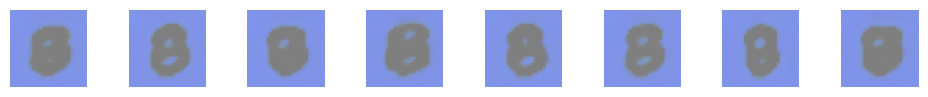

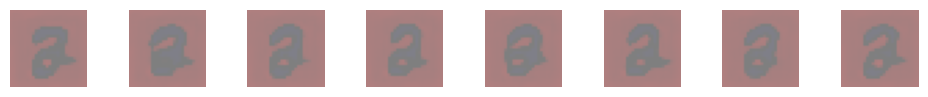

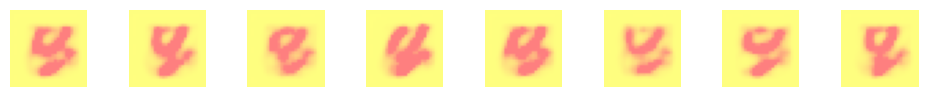

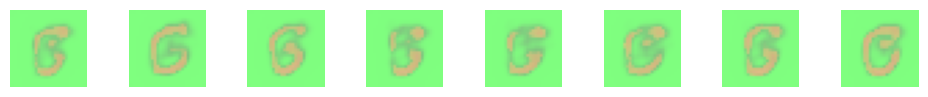

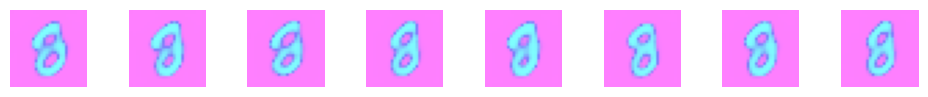

In [54]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, z_dim=10, sigma_=0.1)
for k in [0,2,4,6,8]:
    loc_img = scm_inference.scm_infer([k, k, k+1])
    show_pictures(loc_img)

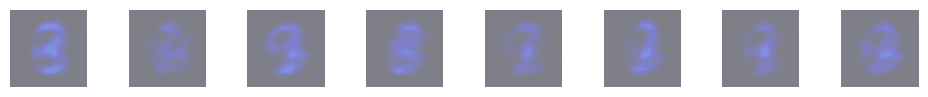

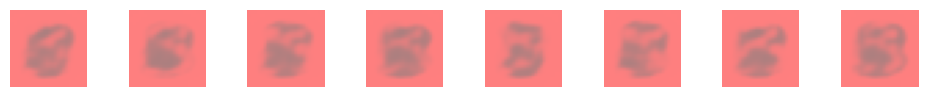

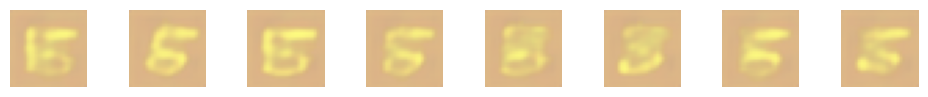

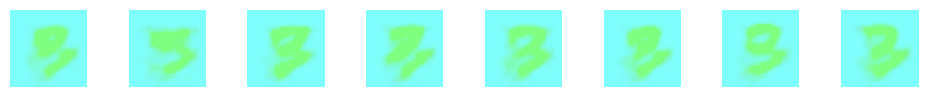

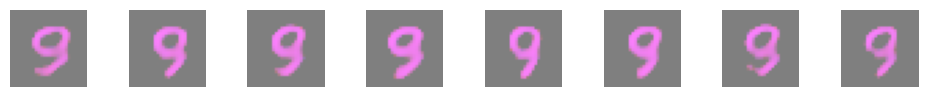

In [55]:
for k in [1,3,5,7,9]:
    loc_img = scm_inference.scm_infer([k, k, (k+1)%10])
    show_pictures(loc_img)

Соберем датасет из сгенерированных интервенций

In [75]:
NUM_SAMPLES_EACH_COMB = 32
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, z_dim=10, BS=NUM_SAMPLES_EACH_COMB, sigma_=0.1)

In [76]:
gen_imgs = []
gen_labels = []
cf_imgs = []
cf_labels = []
for y_1 in tqdm(range(10)):
    for y_2 in range(10):
        for y_3 in range(10):
            if y_1 in [0,2,4,6,8] and y_2 == y_1 and y_3 == y_2 + 1:
                cf_imgs.append(scm_inference.scm_infer([y_1, y_2, y_3]))
                cf_labels.extend([[y_1, y_2, y_3]] * NUM_SAMPLES_EACH_COMB)
            else:
                gen_imgs.append(scm_inference.scm_infer([y_1, y_2, y_3]))
                gen_labels.extend([[y_1, y_2, y_3]] * NUM_SAMPLES_EACH_COMB)

100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


In [77]:
gen_imgs = torch.stack(gen_imgs).flatten(end_dim=1)
cf_imgs = torch.stack(cf_imgs).flatten(end_dim=1)
gen_labels = torch.tensor(gen_labels)
cf_labels = torch.tensor(cf_labels)
gen_imgs.shape, cf_imgs.shape, gen_labels.shape, cf_labels.shape

(torch.Size([31840, 3, 28, 28]),
 torch.Size([160, 3, 28, 28]),
 torch.Size([31840, 3]),
 torch.Size([160, 3]))

In [78]:
class DatasetForInference(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels

    def __getitem__(self, idx):
        ret = {
            'img': self.imgs[idx],
            'label': self.labels[idx],
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [79]:
train_inf_dataset = DatasetForInference(gen_imgs, gen_labels)
cf_inf_dataset = DatasetForInference(cf_imgs, cf_labels)

In [80]:
BATCH_SIZE = 40
train_inf_loader = DataLoader(train_inf_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
cf_inf_loader = DataLoader(cf_inf_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [81]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
simple_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=30)
).to(device)

In [82]:
simple_cnn.load_state_dict(torch.load('classifier.pth', map_location='cpu'))

<All keys matched successfully>

Взять все комбинации Y-ов из train

Сгенерить несколько семплов для каждой с помощью get_pictures

Считаем вероятность для правильного класса (3 чсисла) -> mean, средняя вероятность для каждого из 3 классов. Средняя вероятность правильно предсказанного класса на присутствующих в train комбинациях. Так же для counterfactual, потом берем p(counterfactual) / p(train). -> 1.


C реконструкцией - это другой пайплайн



In [83]:
def get_winner_probs(loader):
    with torch.no_grad():
        winner_probs_1 = []
        winner_probs_2 = []
        winner_probs_3 = []
        for batch in tqdm(loader):
            X_batch = batch['img']
            y_batch = batch['label']
            logits = simple_cnn(X_batch) # (BS, 30)
            y1_preds = F.softmax(logits[:, :10], dim=-1)
            real_y1 = y_batch[:, 0]
            y2_preds = F.softmax(logits[:, 10:20], dim=-1)
            real_y2 = y_batch[:, 1]
            y3_preds = F.softmax(logits[:, 20:], dim=-1)
            real_y3 = y_batch[:, 2]

            winner_probs_1.extend(y1_preds[np.arange(BATCH_SIZE), real_y1].numpy())
            winner_probs_2.extend(y2_preds[np.arange(BATCH_SIZE), real_y2].numpy())
            winner_probs_3.extend(y3_preds[np.arange(BATCH_SIZE), real_y3].numpy())
        return np.stack([winner_probs_1, winner_probs_2, winner_probs_3])

In [84]:
winners_train = get_winner_probs(train_inf_loader)
winners_cf = get_winner_probs(cf_inf_loader)

print('\nTRAIN:', np.mean(winners_train, axis=1))
print('CF:   ', np.mean(winners_cf, axis=1))

  0%|          | 0/796 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 796/796 [00:19<00:00, 51.02it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4/4 [00:00<00:00, 18.11it/s]


TRAIN: [0.4452473  0.36682388 0.42046118]
CF:    [0.2535525  0.20540302 0.42679396]


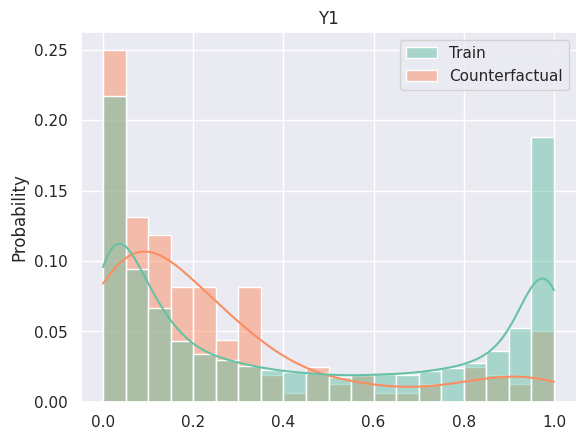

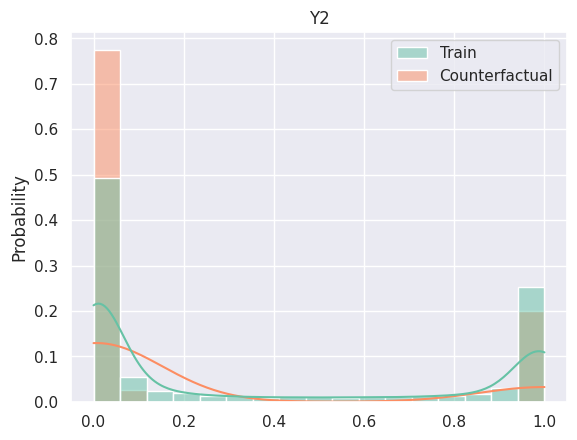

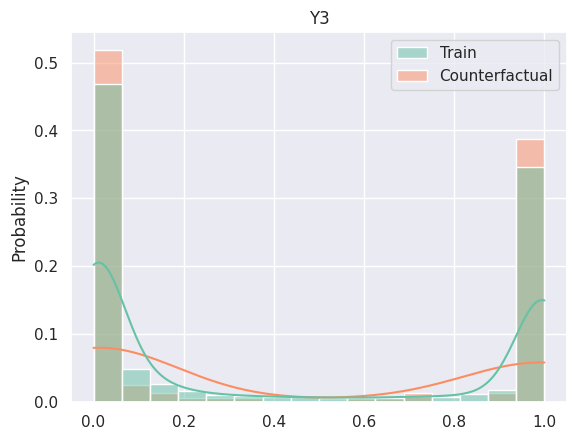

In [85]:
for i in range(3):
    fig, ax = plt.subplots()
    sns.histplot([winners_train[i], winners_cf[i]], kde=True, stat='probability',
                 common_norm=False, ax=ax)
    legend = ax.get_legend()
    handles = legend.legend_handles
    ax.legend(handles, ['Train', 'Counterfactual'])
    ax.set_title('Y'+str(i+1))
    plt.show()